In [1]:
%run -i ./../common/common
%run -i ./zhukovsky
%matplotlib inline

In [134]:
def make_circle(center: Coords, r: float, steps: int = 101) -> Grid:
    x0, y0 = center
    angles = np.linspace(-math.pi, math.pi, steps)
    xs = r * np.cos(angles) + x0
    ys = r * np.sin(angles) + y0
    return (xs, ys)

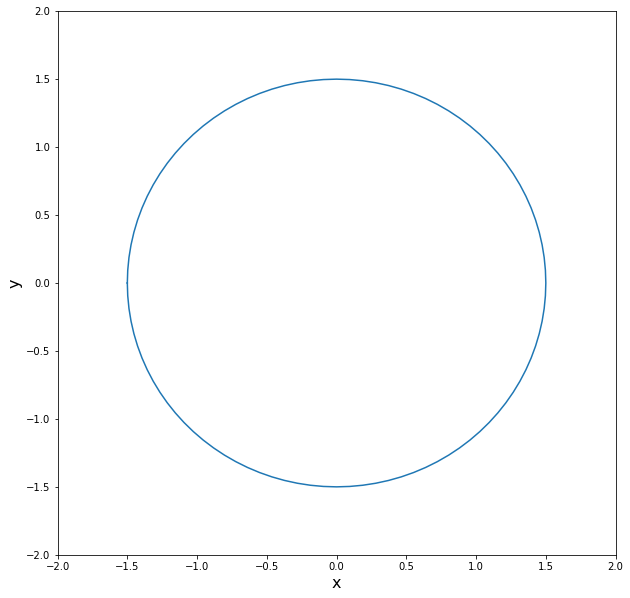

In [135]:
circle = make_circle(Coords(0, 0), 1.5)
size = 10
rect = Rect(-2.0, 2.0, -2.0, 2.0)
setup_fig(rect, size)
plt.plot(*circle)

In [136]:
def zhukovsky_to_shape(grid: Grid, c: complex) -> Grid:
    xs, ys = grid
    cx, cy = c.real, c.imag
    c2x = cx * cx - cy * cy
    c2y = -2.0 * cx * cy
    coeff = xs * xs + ys * ys
    zxs = xs + (xs * c2x + ys * c2y) / coeff
    zys = ys + (xs * c2y - ys * c2x) / coeff
    return (zxs, zys)

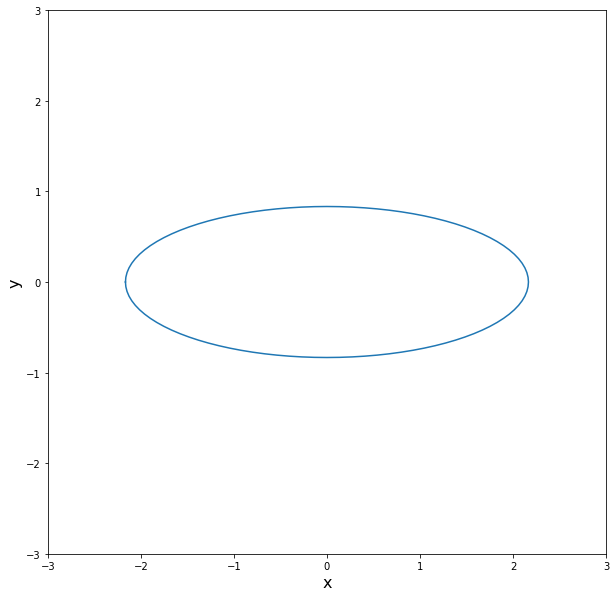

In [137]:
transformed = zhukovsky_to_shape(circle, 1.0 + 0.0j)
rect = Rect(-3.0, 3.0, -3.0, 3.0)
setup_fig(rect, size)
plt.plot(*transformed)

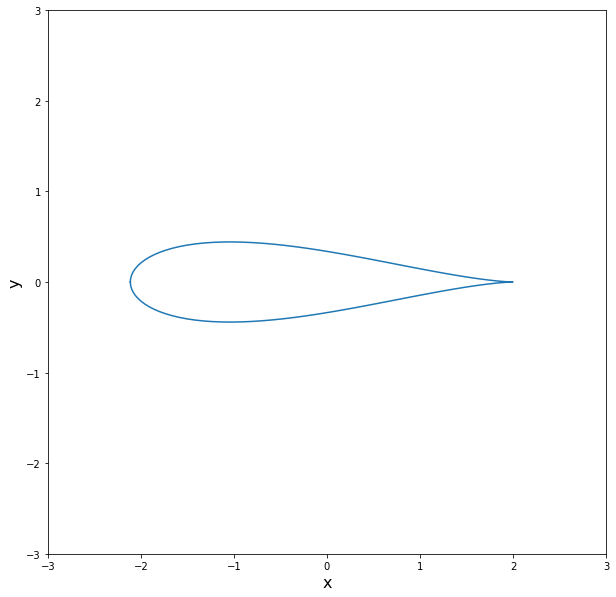

In [138]:
r = 1.2
c = 1.0 + 0.0j
center = Coords(c.real - r, 0.0)
circle = make_circle(center, r)
transformed = zhukovsky_to_shape(circle, c)

size = 10
rect = Rect(-3.0, 3.0, -3.0, 3.0)
setup_fig(rect, size)
plt.plot(*transformed)

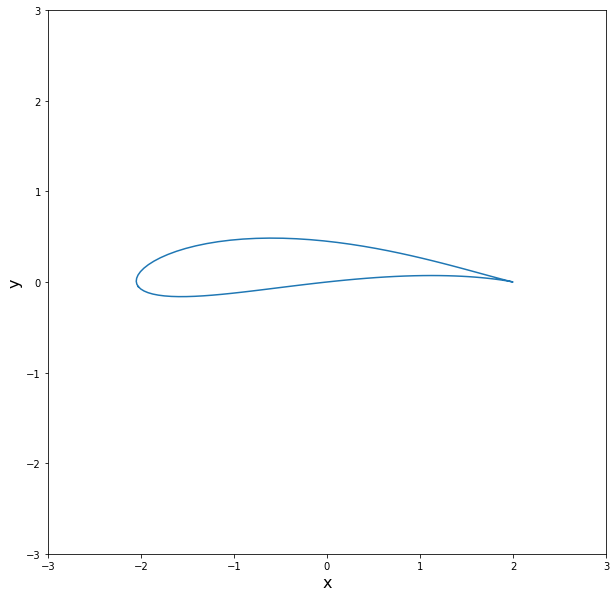

In [139]:
c = 1.0 + 0.0j
center = Coords(0.1, 0.1)
r = math.sqrt((c.real - center.x)**2 + center.y**2)
circle = make_circle(center, r)
transformed = zhukovsky_to_shape(circle, c)

setup_fig(rect, size)
plt.plot(*transformed)

In [140]:
def polar_to_rect(R, Phi) -> Grid:
    X = R * np.cos(Phi)
    Y = R * np.sin(Phi)
    return (X, Y)


In [141]:
def make_polar_grid(r_bounds: (float, float), r_steps: int, phi_steps: int) -> Grid:
    r_lo, r_hi = r_bounds
    rs = np.linspace(r_lo, r_hi, r_steps)
    phis = np.linspace(-math.pi, math.pi, phi_steps)
    return np.meshgrid(rs, phis)

In [142]:
def shift_grid(grid: Grid, shift: Coords):
    xs, ys = grid
    xs += shift.x
    ys += shift.y

In [143]:
def zhukovsky_to_grid(grid: Grid, c: complex) -> Grid:
    xs, ys = zhukovsky_to_shape((grid[0].flatten(), grid[1].flatten()), c)
    xs = xs.reshape(np.shape(grid[0]))
    ys = ys.reshape(np.shape(grid[1]))
    return (xs, ys)
    

In [144]:
rect = Rect(-6.0, 6.0, -6.0, 6.0)
size = 5
radgrid = [*polar_to_rect(*make_polar_grid((1.15, 5.0), 100 + 1, 145 + 1))]
center = Coords(-0.15, 0.0)
shift_grid(radgrid, center)

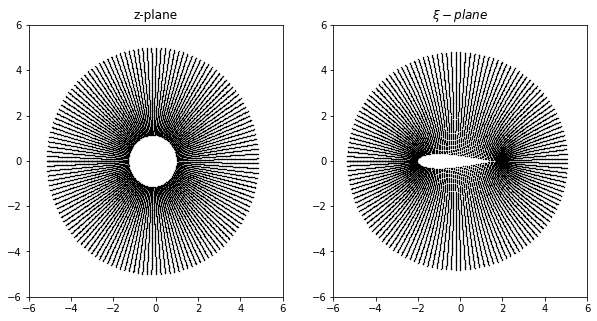

In [145]:
fig = plt.figure(figsize = (size * 2, rect.height / rect.width * size))

zplot = fig.add_subplot(1, 2, 1)
plt.xlim(*rect.span_x)
plt.ylim(*rect.span_y)
plt.xlabel('')
plt.ylabel('')
plt.title('z-plane')
plt.scatter(*radgrid, s = 2, color = '#000000', marker = 'o', linewidth = 0)

c = 1.0 + 0.0j
profile = [*zhukovsky_to_grid(radgrid, c)]
sigma_plot = fig.add_subplot(1, 2, 2)
plt.xlim(*rect.span_x)
plt.ylim(*rect.span_y)
plt.xlabel('')
plt.ylabel('')
plt.title(r'$\xi-plane$')
plt.scatter(*profile, s = 2, color = '#000000', marker = 'o', linewidth = 0)

In [146]:
%run -i ./../source_sink_freestream/freestream
%run -i ./../doublet/doublet

<Figure size 432x288 with 0 Axes>

In [147]:
plt.close()

In [148]:
def strength_for_radius(r: float, u_inf: float) -> float:
    return  2 * math.pi * r * r * u_inf

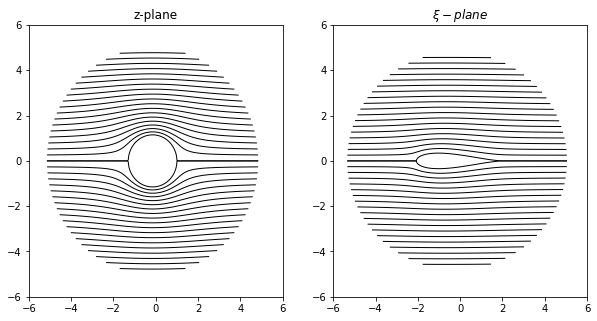

In [149]:
stream = Freestream(1.0)
doublet = Doublet(*center, strength_for_radius(1.15, stream.vel_inf))
levels = [
    np.linspace(-6.0, -0.0000000000001, 25) ,
    np.linspace(+0.0000000000001, 6.0 , 25)
]
levels = np.concatenate(levels)

fig = plt.figure(figsize = (size * 2, rect.height / rect.width * size))

zplot = fig.add_subplot(1, 2, 1)
plt.xlim(*rect.span_x)
plt.ylim(*rect.span_y)
plt.xlabel('')
plt.ylabel('')
plt.title('z-plane')
pot = stream.potential(radgrid) + doublet.potential(radgrid)
plt.contour(*radgrid, pot,
    levels = levels,
    colors = ['#000000'],
    linestyles = 'solid',
    linewidths = 1.0)

sigma_plot = fig.add_subplot(1, 2, 2)
plt.xlim(*rect.span_x)
plt.ylim(*rect.span_y)
plt.xlabel('')
plt.ylabel('')
plt.title(r'$\xi - plane$')
pot = stream.potential(radgrid) + doublet.potential(radgrid)
pot = pot.reshape(np.shape(profile[0]))
plt.contour(*profile, pot,
    levels = levels,
    colors = ['#000000'],
    linestyles = 'solid',
    linewidths = 1.0)

In [158]:
def zhukovsky_deriv_coords(coords: Grid, c: complex) -> 'numpy.ndarray':
    points = -np.square(c/coords) + 1.0
    return points.reshape(coords.shape)

def grid_to_complex(grid: Grid) -> 'numpy.ndarray':
    xs, ys = grid
    cgrid = np.fromiter(
        (complex(x, y) for x in xs.flat for y in ys.flat),
        dtype = complex,
        count = xs.size
    )
    return cgrid.reshape(xs.shape)

def complex_to_grid(cpoints: 'numpy.ndarray') -> Grid:
    xs = np.fromiter(
        (val.real for val in cpoints.flat),
        dtype = float,
        count = cpoints.size
    )
    ys = np.fromiter(
        (val.imag for val in cpoints.flat),
        dtype = float,
        count = cpoints.size
    )
    shape = cpoints.shape
    return (xs.reshape(shape), ys.reshape(shape))

def deriv_with_zhukovsky(values: Grid, coords: Grid, c: complex) -> Grid:
    xs, ys = values
    cvalues = grid_to_complex((xs, -ys))
    ccoords = grid_to_complex(coords)
    #ccoords = zhukovsky_deriv_coords(ccoords, c)
    cvalues /= 1 - (c / ccoords)**2
    #cvalues /= ccoords
    res_x, res_y = complex_to_grid(cvalues)
    return (res_x, -res_y)

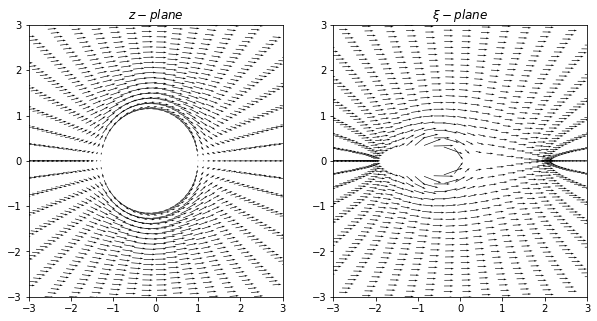

In [165]:
sparse_radgrid = [*polar_to_rect(*make_polar_grid((1.15, 4.0), 25 + 1, 50 + 1))]
center = Coords(-0.15, 0.0)
shift_grid(sparse_radgrid, center)

rect = Rect(-3.0, 3.0, -3.0, 3.0)
fig = plt.figure(figsize = (size * 2, rect.height / rect.width * size))
c = complex(1.0, 0.0)
profile = [*zhukovsky_to_grid(sparse_radgrid, c)]

zplot = fig.add_subplot(1, 2, 1)
plt.xlim(*rect.span_x)
plt.ylim(*rect.span_y)
plt.xlabel('')
plt.ylabel('')
plt.title('$z - plane$')
vel = sum_pair(stream.velocity(sparse_radgrid), doublet.velocity(sparse_radgrid))
plt.quiver(*sparse_radgrid, *vel, units = 'xy', scale = 5.0)

sigma_plot = fig.add_subplot(1, 2, 2)
plt.xlim(*rect.span_x)
plt.ylim(*rect.span_y)
plt.xlabel('')
plt.ylabel('')
plt.title(r'$\xi - plane$')
vel = sum_pair(stream.velocity(profile), doublet.velocity(profile))
#vel = deriv_with_zhukovsky(vel, profile, c)
U, V = vel
VEL = U - V * complex(0.0, 1.0)
X, Y = profile
Z = X + Y * complex(0.0, 1.0)
VEL2 = VEL / (1.0 - np.square(c / Z))
U2 = VEL2.real
V2 = VEL2.imag
plt.quiver(*profile, U2, -V2, units = 'xy', scale = 5.0)